|평가문항	|상세기준|
|:-|:-|
|1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.	|3가지 이상의 모델이 성공적으로 시도됨|
|2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.	|gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함|
|3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.	|네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함|

# 6-1. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기
이전 스텝까지는 영문 텍스트의 감정 분석을 진행해 보았습니다.  
그렇다면 이번에는 한국어 텍스트의 감정 분석을 진행해 보면 어떨까요?  
오늘 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus입니다.
## 라이브러리 버전 확인

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 1) 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


146183개의 리뷰로 구성되어 있으며, 긍정은 1, 부정은 0 라벨이 달려있다.

## 2) 데이터로더 구성
실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 `imdb.data_loader()` 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 `word_to_index` 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 `imdb.data_loader()`와 동일하게 동작하는 자신만의 `data_loader`를 만들어 보는 것으로 시작합니다. `data_loader` 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)   # 데이터 중복 제거
    train_data = train_data.dropna(how = 'any')   # NaN 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)   # 데이터 중복 제거
    test_data = test_data.dropna(how = 'any')   # NaN 결측치 제거
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 한국어 토크나이저로 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 한국어 토크나이저로 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<EOS>', '<UNK>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    # X_train, y_train, X_test, y_test, word_to_index 리턴
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
len(X_train), len(y_train), len(X_test), len(y_test)

(146182, 146182, 49157, 49157)

In [6]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[5])

영화


In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [9]:
# encode된 텍스트가 정상적으로 decode 되는지 확인
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


## 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [10]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [11]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 4) 모델 구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [12]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [13]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [14]:
import numpy as np

# 전체 훈련 데이터를 셔플하기 위한 인덱스를 무작위로 생성
indices = np.arange(partial_x_train.shape[0])
np.random.shuffle(indices)

# 무작위로 섞인 인덱스를 사용하여 데이터와 레이블을 선택
partial_x_train = partial_x_train[indices][:10000]
partial_y_train = partial_y_train[indices][:10000]

print(partial_x_train.shape)
print(partial_y_train.shape)

(10000, 41)
(10000,)


In [15]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 필요할 때 GPU 메모리 증가를 허용하도록 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

Physical devices cannot be modified after being initialized


## 5) 모델 훈련 개시

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
79/79 [==============================] - 4s 8ms/step - loss: 0.6888 - accuracy: 0.5407 - val_loss: 0.6659 - val_accuracy: 0.6265
Epoch 2/20
79/79 [==============================] - 0s 6ms/step - loss: 0.5050 - accuracy: 0.7787 - val_loss: 0.4362 - val_accuracy: 0.7976
Epoch 3/20
79/79 [==============================] - 0s 6ms/step - loss: 0.3039 - accuracy: 0.8807 - val_loss: 0.4223 - val_accuracy: 0.8116
Epoch 4/20
79/79 [==============================] - 0s 6ms/step - loss: 0.2086 - accuracy: 0.9258 - val_loss: 0.4548 - val_accuracy: 0.8079
Epoch 5/20
79/79 [==============================] - 0s 6ms/step - loss: 0.1443 - accuracy: 0.9522 - val_loss: 0.5056 - val_accuracy: 0.8014
Epoch 6/20
79/79 [==============================] - 0s 6ms/step - loss: 0.0968 - accuracy: 0.9709 - val_loss: 0.5722 - val_accuracy: 0.8022
Epoch 7/20
79/79 [==============================] - 0s 6ms/step - loss: 0.0664 - accuracy: 0.9826 - val_loss: 0.6456 - val_accuracy: 0.7961
Epoch 8/20
79/79 [==

In [17]:
# 학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 1.1968 - accuracy: 0.7751
[1.1967928409576416, 0.7751083374023438]


## 6) Loss, Accuracy 그래프 시각화


In [18]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


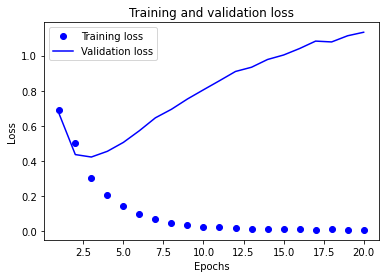

In [19]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

3 에폭 가량부터 과적합이 나타나고 있다.

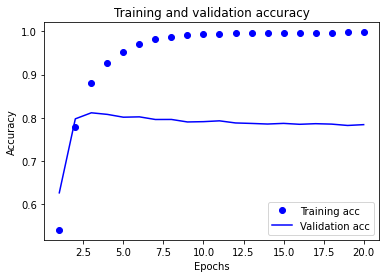

In [20]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 4) 모델 구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [21]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [22]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [23]:
import numpy as np

# 전체 훈련 데이터를 셔플하기 위한 인덱스를 무작위로 생성
indices = np.arange(partial_x_train.shape[0])
np.random.shuffle(indices)

# 무작위로 섞인 인덱스를 사용하여 데이터와 레이블을 선택
partial_x_train = partial_x_train[indices][:10000]
partial_y_train = partial_y_train[indices][:10000]

print(partial_x_train.shape)
print(partial_y_train.shape)

(10000, 41)
(10000,)


In [24]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 필요할 때 GPU 메모리 증가를 허용하도록 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

Physical devices cannot be modified after being initialized


## 5) 모델 훈련 개시

In [25]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
79/79 [==============================] - 1s 10ms/step - loss: 0.6918 - accuracy: 0.5331 - val_loss: 0.6845 - val_accuracy: 0.6245
Epoch 2/20
79/79 [==============================] - 0s 6ms/step - loss: 0.5470 - accuracy: 0.7666 - val_loss: 0.4368 - val_accuracy: 0.7970
Epoch 3/20
79/79 [==============================] - 0s 6ms/step - loss: 0.3255 - accuracy: 0.8654 - val_loss: 0.4185 - val_accuracy: 0.8073
Epoch 4/20
79/79 [==============================] - 0s 6ms/step - loss: 0.2281 - accuracy: 0.9142 - val_loss: 0.4506 - val_accuracy: 0.8077
Epoch 5/20
79/79 [==============================] - 0s 6ms/step - loss: 0.1665 - accuracy: 0.9422 - val_loss: 0.5245 - val_accuracy: 0.7925
Epoch 6/20
79/79 [==============================] - 0s 6ms/step - loss: 0.1167 - accuracy: 0.9632 - val_loss: 0.5668 - val_accuracy: 0.8005
Epoch 7/20
79/79 [==============================] - 0s 6ms/step - loss: 0.0832 - accuracy: 0.9769 - val_loss: 0.6424 - val_accuracy: 0.7947
Epoch 8/20
79/79 [=

In [26]:
# 학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 1.3494 - accuracy: 0.7698
[1.3493598699569702, 0.7698191404342651]


## 6) Loss, Accuracy 그래프 시각화


In [27]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


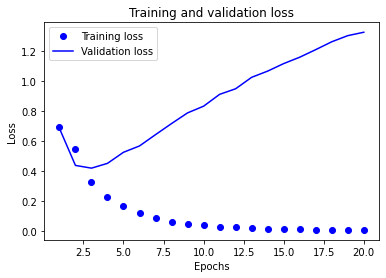

In [28]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

3 에폭 가량부터 과적합이 나타나고 있다.

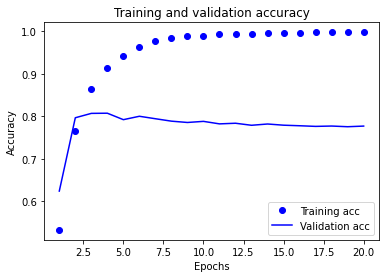

In [29]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

모델을 약간 변경해보자.

In [30]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout (Dropout)            (None, 8)                

In [31]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [32]:
import numpy as np

# 전체 훈련 데이터를 셔플하기 위한 인덱스를 무작위로 생성
indices = np.arange(partial_x_train.shape[0])
np.random.shuffle(indices)

# 무작위로 섞인 인덱스를 사용하여 데이터와 레이블을 선택
partial_x_train = partial_x_train[indices][:10000]
partial_y_train = partial_y_train[indices][:10000]

print(partial_x_train.shape)
print(partial_y_train.shape)

(10000, 41)
(10000,)


## 5) 모델 훈련 개시

In [33]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/50
79/79 [==============================] - 1s 8ms/step - loss: 0.6921 - accuracy: 0.5125 - val_loss: 0.6885 - val_accuracy: 0.5580
Epoch 2/50
79/79 [==============================] - 0s 6ms/step - loss: 0.6413 - accuracy: 0.6495 - val_loss: 0.5401 - val_accuracy: 0.7795
Epoch 3/50
79/79 [==============================] - 0s 6ms/step - loss: 0.4938 - accuracy: 0.7946 - val_loss: 0.4663 - val_accuracy: 0.7936
Epoch 4/50
79/79 [==============================] - 0s 6ms/step - loss: 0.3932 - accuracy: 0.8638 - val_loss: 0.4372 - val_accuracy: 0.8049
Epoch 5/50
79/79 [==============================] - 0s 6ms/step - loss: 0.3422 - accuracy: 0.8946 - val_loss: 0.4414 - val_accuracy: 0.8027
Epoch 6/50
79/79 [==============================] - 0s 6ms/step - loss: 0.2987 - accuracy: 0.9146 - val_loss: 0.4744 - val_accuracy: 0.7984
Epoch 7/50
79/79 [==============================] - 0s 6ms/step - loss: 0.2682 - accuracy: 0.9268 - val_loss: 0.5390 - val_accuracy: 0.7902
Epoch 8/50
79/79 [==

In [34]:
# 학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5786 - accuracy: 0.7887
[0.5786457061767578, 0.7887381315231323]


## 6) Loss, Accuracy 그래프 시각화


In [35]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


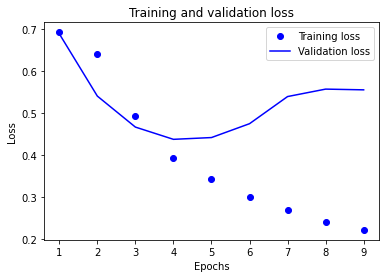

In [36]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

4 에폭 가량부터 과적합이 나타나고 있다.

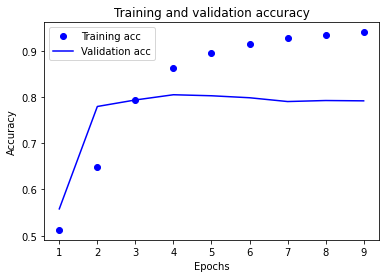

In [37]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

데이터 수를 늘려보자.

In [38]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                

In [39]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [40]:
import numpy as np

# 전체 훈련 데이터를 셔플하기 위한 인덱스를 무작위로 생성
indices = np.arange(partial_x_train.shape[0])
np.random.shuffle(indices)

# 무작위로 섞인 인덱스를 사용하여 데이터와 레이블을 선택
partial_x_train = partial_x_train[indices][:50000]
partial_y_train = partial_y_train[indices][:50000]

print(partial_x_train.shape)
print(partial_y_train.shape)

(50000, 41)
(50000,)


## 5) 모델 훈련 개시

In [41]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/50
391/391 [==============================] - 2s 5ms/step - loss: 0.5635 - accuracy: 0.6936 - val_loss: 0.3886 - val_accuracy: 0.8321
Epoch 2/50
391/391 [==============================] - 2s 4ms/step - loss: 0.4088 - accuracy: 0.8320 - val_loss: 0.3589 - val_accuracy: 0.8419
Epoch 3/50
391/391 [==============================] - 2s 4ms/step - loss: 0.3573 - accuracy: 0.8594 - val_loss: 0.3600 - val_accuracy: 0.8411
Epoch 4/50
391/391 [==============================] - 2s 4ms/step - loss: 0.3195 - accuracy: 0.8778 - val_loss: 0.3708 - val_accuracy: 0.8385
Epoch 5/50
391/391 [==============================] - 2s 4ms/step - loss: 0.2836 - accuracy: 0.8947 - val_loss: 0.4025 - val_accuracy: 0.8345
Epoch 6/50
391/391 [==============================] - 2s 4ms/step - loss: 0.2441 - accuracy: 0.9110 - val_loss: 0.4466 - val_accuracy: 0.8327
Epoch 7/50
391/391 [==============================] - 2s 4ms/step - loss: 0.2106 - accuracy: 0.9255 - val_loss: 0.5233 - val_accuracy: 0.8268


In [42]:
# 학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5288 - accuracy: 0.8260
[0.5287981629371643, 0.8259861469268799]


## 6) Loss, Accuracy 그래프 시각화


In [43]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


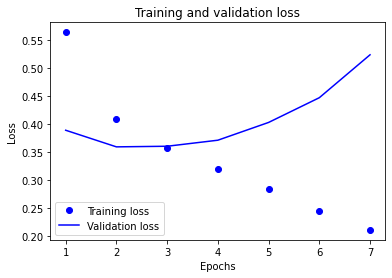

In [44]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

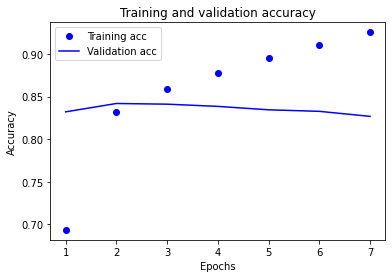

In [45]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

모델 변경

In [46]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          7200      
_________________________________________________________________
batch_normalization (BatchNo (None, None, 32)          128       
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 16)          3600      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 16)         

In [47]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [48]:
import numpy as np

# 전체 훈련 데이터를 셔플하기 위한 인덱스를 무작위로 생성
indices = np.arange(partial_x_train.shape[0])
np.random.shuffle(indices)

# 무작위로 섞인 인덱스를 사용하여 데이터와 레이블을 선택
partial_x_train = partial_x_train[indices][:50000]
partial_y_train = partial_y_train[indices][:50000]

print(partial_x_train.shape)
print(partial_y_train.shape)

(50000, 41)
(50000,)


## 5) 모델 훈련 개시

In [49]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/50
391/391 [==============================] - 4s 7ms/step - loss: 0.8148 - accuracy: 0.5584 - val_loss: 0.7298 - val_accuracy: 0.5041
Epoch 2/50
391/391 [==============================] - 2s 6ms/step - loss: 0.5687 - accuracy: 0.7084 - val_loss: 0.4767 - val_accuracy: 0.7984
Epoch 3/50
391/391 [==============================] - 3s 6ms/step - loss: 0.4565 - accuracy: 0.8039 - val_loss: 0.4037 - val_accuracy: 0.8278
Epoch 4/50
391/391 [==============================] - 2s 6ms/step - loss: 0.3950 - accuracy: 0.8432 - val_loss: 0.3908 - val_accuracy: 0.8262
Epoch 5/50
391/391 [==============================] - 2s 6ms/step - loss: 0.3534 - accuracy: 0.8662 - val_loss: 0.3960 - val_accuracy: 0.8256
Epoch 6/50
391/391 [==============================] - 2s 6ms/step - loss: 0.3259 - accuracy: 0.8798 - val_loss: 0.3927 - val_accuracy: 0.8309
Epoch 7/50
391/391 [==============================] - 2s 6ms/step - loss: 0.2948 - accuracy: 0.8933 - val_loss: 0.3997 - val_accuracy: 0.8282
Epoch 

In [50]:
# 학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4579 - accuracy: 0.8188
[0.4578666687011719, 0.8187847137451172]


## 6) Loss, Accuracy 그래프 시각화


In [51]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


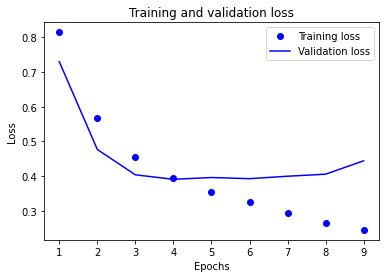

In [52]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

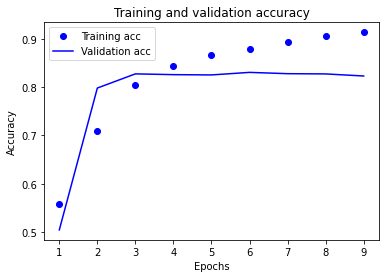

In [53]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

LSTM 추가

In [54]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 32)          7200      
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 32)          128       
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 16)          3600      
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 16)         

In [55]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [56]:
import numpy as np

# 전체 훈련 데이터를 셔플하기 위한 인덱스를 무작위로 생성
indices = np.arange(partial_x_train.shape[0])
np.random.shuffle(indices)

# 무작위로 섞인 인덱스를 사용하여 데이터와 레이블을 선택
partial_x_train = partial_x_train[indices][:50000]
partial_y_train = partial_y_train[indices][:50000]

print(partial_x_train.shape)
print(partial_y_train.shape)

(50000, 41)
(50000,)


## 5) 모델 훈련 개시

In [57]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/50
391/391 [==============================] - 5s 8ms/step - loss: 0.7368 - accuracy: 0.5041 - val_loss: 0.6924 - val_accuracy: 0.5133
Epoch 2/50
391/391 [==============================] - 3s 7ms/step - loss: 0.6764 - accuracy: 0.5683 - val_loss: 0.5682 - val_accuracy: 0.7264
Epoch 3/50
391/391 [==============================] - 3s 8ms/step - loss: 0.5078 - accuracy: 0.7722 - val_loss: 0.4020 - val_accuracy: 0.8249
Epoch 4/50
391/391 [==============================] - 3s 7ms/step - loss: 0.4053 - accuracy: 0.8378 - val_loss: 0.4076 - val_accuracy: 0.8094
Epoch 5/50
391/391 [==============================] - 3s 7ms/step - loss: 0.3506 - accuracy: 0.8651 - val_loss: 0.3949 - val_accuracy: 0.8142
Epoch 6/50
391/391 [==============================] - 3s 7ms/step - loss: 0.3183 - accuracy: 0.8808 - val_loss: 0.3766 - val_accuracy: 0.8324
Epoch 7/50
391/391 [==============================] - 3s 7ms/step - loss: 0.2851 - accuracy: 0.8979 - val_loss: 0.3896 - val_accuracy: 0.8284
Epoch 

In [58]:
# 학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4645 - accuracy: 0.8255
[0.4645332396030426, 0.8254978656768799]


## 6) Loss, Accuracy 그래프 시각화


In [59]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


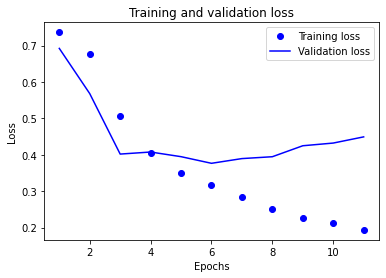

In [60]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

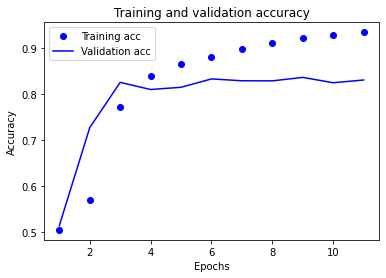

In [61]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

아무래도 단순 모델 변경으로는 한계가 있는 듯...

## 7) 학습된 Embedding 레이어 분석

In [62]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 32)


In [63]:
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [64]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['감동']
vector

array([-0.01853448,  0.05845105,  0.043738  , -0.06605332, -0.00671468,
        0.03823937,  0.04069462,  0.11491743,  0.00713293, -0.00939558,
       -0.03572506, -0.10353541,  0.05003301, -0.06353195, -0.05820234,
        0.03608347, -0.0839581 , -0.03222273,  0.01919852, -0.08681165,
       -0.0785211 , -0.10054182,  0.05900731,  0.09011723, -0.02002627,
       -0.06783552, -0.07179434, -0.06734256,  0.04622454, -0.05345967,
       -0.06285743, -0.06303083], dtype=float32)

In [65]:
word_vectors.similar_by_word("감동")

[('물질', 0.7684443593025208),
 ('빅뱅', 0.7606387138366699),
 ('향해', 0.7519015073776245),
 ('공각', 0.7408796548843384),
 ('어울려', 0.7283622026443481),
 ('인간미', 0.7214627861976624),
 ('99', 0.7198526263237),
 ('아닐까', 0.7195970416069031),
 ('유년', 0.7146461606025696),
 ('데뷔작', 0.7125999331474304)]

관련이 있어 보이는 단어들도 있고 아닌 단어들도 있음.

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요.  
[참고링크1](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models)  
[참고링크2](https://radimrehurek.com/gensim/models/keyedvectors.html)

In [66]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_path = '/aiffel/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_path)
vector = word2vec.wv['감동']

In [67]:
vector

array([ 2.0615332 , -1.8058181 , -3.8560703 ,  0.19584662,  3.0254989 ,
       -2.5406559 ,  1.4497426 , -0.8907619 , -0.5350154 , -0.28915498,
       -0.04039751, -1.5070994 , -1.5159569 , -1.4451234 ,  1.2730805 ,
        1.219924  ,  1.1764907 , -1.1386696 ,  1.4214209 ,  0.03967131,
       -2.1550455 ,  2.365588  ,  2.5686727 , -2.298423  , -0.11259492,
        0.26295963, -1.3272469 , -0.933552  ,  4.1928024 , -4.142401  ,
       -3.6939445 ,  0.7796591 , -0.9809508 ,  0.3209224 ,  0.69489354,
        0.35386428, -2.5914404 ,  0.9266287 , -1.8625584 ,  0.7818586 ,
       -0.9435029 , -0.50120497,  1.4713919 ,  4.4542685 , -1.2020006 ,
        0.41612652,  2.3063416 , -0.41137695,  4.462475  , -1.5086855 ,
        2.0054195 ,  0.8322103 ,  3.0386746 , -1.1280597 , -0.819387  ,
       -3.6409898 ,  1.4442042 , -0.6339732 ,  0.25369656, -0.39272726,
        1.6376917 , -2.6886675 ,  0.41585886, -2.772139  ,  0.59364617,
        0.98523784,  2.0588415 ,  0.22607008, -1.26653   , -1.01

In [68]:
word2vec.wv.similar_by_word("감동")

[('감격', 0.8046045899391174),
 ('감탄', 0.7326707243919373),
 ('매혹', 0.7267226576805115),
 ('매력', 0.7088802456855774),
 ('감명', 0.7069407105445862),
 ('웃음', 0.7015025615692139),
 ('열정', 0.6936471462249756),
 ('칭찬', 0.6831857562065125),
 ('실망', 0.6779423952102661),
 ('슬픔', 0.6770600080490112)]

의미적 유사도가 가까운 것들끼리 잘 학습되었다.

In [70]:
word_vector_dim = word2vec.wv.vector_size  # Word2Vec 모델의 벡터 차원

# 새로운 word_vector_dim에 맞춰 embedding_matrix 초기화
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    word = index_to_word[i]  # i번째 단어
    if word in word2vec.wv:  # .wv 속성을 사용하여 단어 벡터에 접근
        embedding_matrix[i] = word2vec.wv[word]  # 해당 단어의 벡터를 가져온다

In [83]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

In [84]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/50
98/98 [==============================] - 2s 9ms/step - loss: 0.6623 - accuracy: 0.5912 - val_loss: 0.6008 - val_accuracy: 0.6874
Epoch 2/50
98/98 [==============================] - 1s 5ms/step - loss: 0.5389 - accuracy: 0.7308 - val_loss: 0.5237 - val_accuracy: 0.7416
Epoch 3/50
98/98 [==============================] - 1s 5ms/step - loss: 0.4654 - accuracy: 0.7822 - val_loss: 0.4852 - val_accuracy: 0.7687
Epoch 4/50
98/98 [==============================] - 1s 5ms/step - loss: 0.4177 - accuracy: 0.8121 - val_loss: 0.4618 - val_accuracy: 0.7887
Epoch 5/50
98/98 [==============================] - 1s 6ms/step - loss: 0.3786 - accuracy: 0.8342 - val_loss: 0.4466 - val_accuracy: 0.7956
Epoch 6/50
98/98 [==============================] - 1s 5ms/step - loss: 0.3498 - accuracy: 0.8491 - val_loss: 0.4367 - val_accuracy: 0.8054
Epoch 7/50
98/98 [==============================] - 1s 5ms/step - loss: 0.3201 - accuracy: 0.8660 - val_loss: 0.4436 - val_accuracy: 0.8094
Epoch 8/50
98/98 [==

In [85]:
# 학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4717 - accuracy: 0.8141
[0.4716634452342987, 0.814126193523407]


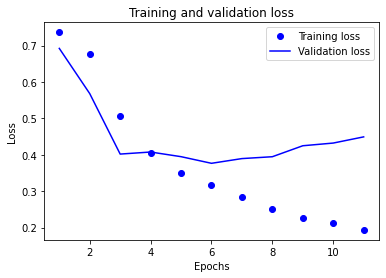

In [86]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

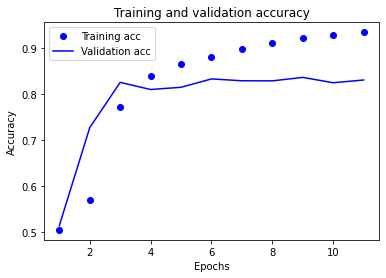

In [87]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

아직도 과적합...규제 추가해보자.

In [88]:
from tensorflow.keras import regularizers

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 35, 32)            22432     
_________________________________________________________________
batch_normalization_14 (Batc (None, 35, 32)            128       
_________________________________________________________________
dropout_16 (Dropout)         (None, 35, 32)            0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 7, 32)             0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 1, 16)             3600      
_________________________________________________________________
batch_normalization_15 (Batc (None, 1, 16)           

In [90]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/50
98/98 [==============================] - 4s 15ms/step - loss: 0.7731 - accuracy: 0.5259 - val_loss: 0.6899 - val_accuracy: 0.6064
Epoch 2/50
98/98 [==============================] - 1s 9ms/step - loss: 0.6894 - accuracy: 0.5857 - val_loss: 0.6370 - val_accuracy: 0.6849
Epoch 3/50
98/98 [==============================] - 1s 9ms/step - loss: 0.6315 - accuracy: 0.6574 - val_loss: 0.5855 - val_accuracy: 0.7256
Epoch 4/50
98/98 [==============================] - 1s 9ms/step - loss: 0.5890 - accuracy: 0.7062 - val_loss: 0.5402 - val_accuracy: 0.7517
Epoch 5/50
98/98 [==============================] - 1s 8ms/step - loss: 0.5531 - accuracy: 0.7404 - val_loss: 0.5053 - val_accuracy: 0.7700
Epoch 6/50
98/98 [==============================] - 1s 8ms/step - loss: 0.5200 - accuracy: 0.7664 - val_loss: 0.4719 - val_accuracy: 0.7853
Epoch 7/50
98/98 [==============================] - 1s 9ms/step - loss: 0.4937 - accuracy: 0.7837 - val_loss: 0.4567 - val_accuracy: 0.7952
Epoch 8/50
98/98 [=

In [91]:
# 학습이 끝난 모델을 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4062 - accuracy: 0.8284
[0.4061806797981262, 0.8284069299697876]


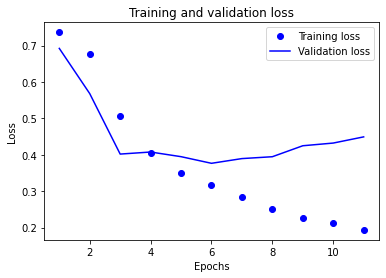

In [92]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

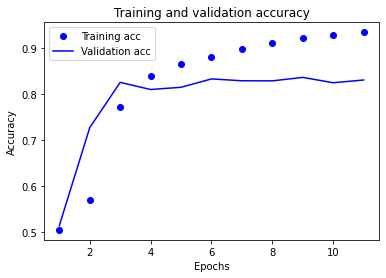

In [93]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

성능이 크게 향상되지는 않았고 (0.8255 -> 0.8284), 아직 과적합 문제가 남아있다.

# 회고
저는....여기까지인 것 같습니다....
이제 슬슬 내용 파악이 어렵네요 흑흑...